In [1]:
model_code = "02_15_3"
f_log_dir = "./"+model_code+"_log"
f_log_dir_train = "./"+model_code+"_log/training/"
f_log_dir_val = "./"+model_code+"_log/validate/"
f_chkpt_h5 = model_code+"_model"+".h5"
f_model_json = model_code+"_model_json"+".json"
f_model_weights = model_code+"_model_weights"+".h5"
f_infer_all = model_code+"_model_infer"+".txt"
f_model_png = model_code+"_model_image"+".png"

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from pythainlp.tokenize import word_tokenize
from gensim.models import KeyedVectors
from itertools import cycle
from scipy import interp
from collections import Counter
from pprint import pprint

import dill as pickle
import numpy as np
import pandas as pd
import io
import sys
import graphviz
import pydot

#matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

#keras
import keras.models
from keras.models import Sequential
from keras.layers import Dense, AveragePooling1D, SimpleRNN
from keras.layers import LSTM, Convolution1D, Flatten, Dropout, Conv1D
from keras.layers import SpatialDropout1D, MaxPooling1D, TimeDistributed 
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard
from keras import losses
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import load_model

#sklearn
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn import svm, datasets

#more

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import tensorflow as tf

class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = f_log_dir_train #os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = f_log_dir_val #os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()

In [4]:
from rwa import RWA
def slice_last_timedimension(x):
    return x[:, -1, :]

In [5]:
#Thai2Vec Pre-trained Word Embedding
def sentence_vectorizer(ss,model,dim=300,use_mean=False):
    s = word_tokenize(ss)
    vec = np.zeros((1,dim))
    for word in s:
        if word in model.wv.index2word:
            vec+= model.wv.word_vec(word)
        else: pass
    if use_mean: vec /= len(s)
    return(vec)

#load into gensim
model = KeyedVectors.load_word2vec_format('thai2vec.vec',binary=False)

#create dataframe
thai2dict = {}
for word in model.index2word:
    thai2dict[word] = model[word]
thai2vec = pd.DataFrame.from_dict(thai2dict,orient='index')
#thai2vec.head()
print(len(thai2vec))

51358


In [6]:
#Our Train/Test/Validate Data
data_text = pd.read_csv('SentiFine_deepcut_raw_text_only_copy.txt', header=None, encoding="UTF-8", names = ["Text"])
data_label = pd.read_csv('SentiFine_raw_label_only.txt', header=None, encoding="UTF-8", names = ["Sentiment"])
data = pd.DataFrame({'text': data_text['Text'],
                    'sentiment': data_label['Sentiment']})
data.head()

sentiment                                               text
0   neutral  จิบชา ชิม เค้ก   กับ ร้าน ละเลียด   ธุรกิจ สอง...
1   neutral  ศัลยกรรม ตุ๊กตา   บลายล์   เปลี่ยน โฉม ใบ หน้า...
2   neutral  งาน THAIFEX - World   of   food   ASIA   ประกา...
3   neutral  เฟอร์นิเจอร์ ปลูก ต้น ไม้ นวัตกรรม ดีไซน์ ลด โ...
4   neutral  เผย   อุตไทยโตสวน กระแส   จี้ ปั้น แรงงาน ยอด ...

In [7]:
#Build up DataFrame for our Train/Test/Validate Data

#Decode Label from text to Int
temp_sentiment_int = []
for index in range(len(data)):
    if data['sentiment'][index] == 'neutral':
        temp_sentiment_int.append(0)
    elif data['sentiment'][index] == 'negative':
        temp_sentiment_int.append(1)
    elif data['sentiment'][index] == 'positive':
        temp_sentiment_int.append(2)        
    else:
        temp_sentiment_int.append("?")

#count the frequency of each word in a word list
reviews = data['text']
all_text = ' '.join(reviews)
words = all_text.split()
counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)

#assign word to int and build a new list of data with int
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)   }
reviews_ints = []
for each in reviews:
    reviews_ints.append([vocab_to_int[word] for word in each.split()])
    
review_lens = Counter([len(x) for x in reviews_ints])

non_zero_idx = [ii for ii, review in enumerate(reviews_ints) if len(review) != 0]

reviews_ints = [reviews_ints[ii] for ii in non_zero_idx]

data = pd.DataFrame({'Text': data['text'],
                    'Text_int': reviews_ints,
                    'Sentiment': data['sentiment'],
                    'Sentiment_int': temp_sentiment_int
                    })

data.head()

Sentiment  Sentiment_int                                               Text  \
0   neutral              0  จิบชา ชิม เค้ก   กับ ร้าน ละเลียด   ธุรกิจ สอง...   
1   neutral              0  ศัลยกรรม ตุ๊กตา   บลายล์   เปลี่ยน โฉม ใบ หน้า...   
2   neutral              0  งาน THAIFEX - World   of   food   ASIA   ประกา...   
3   neutral              0  เฟอร์นิเจอร์ ปลูก ต้น ไม้ นวัตกรรม ดีไซน์ ลด โ...   
4   neutral              0  เผย   อุตไทยโตสวน กระแส   จี้ ปั้น แรงงาน ยอด ...   

                                            Text_int  
0  [3373, 5464, 1265, 218, 102, 4433, 140, 718, 6...  
1  [6451, 3431, 6579, 608, 1063, 626, 215, 1723, ...  
2  [130, 6965, 5, 2950, 4426, 7509, 2407, 207, 32...  
3  [2195, 1369, 376, 2039, 1480, 4654, 33, 101, 382]  
4  [99, 6425, 567, 662, 876, 520, 131, 1723, 2398...

In [8]:
#Define some static parameters of model

# Embedding
max_features = 20000
maxlen = 100
embedding_size = 128

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
batch_size = 30
epochs = 30

In [9]:
#Build Up X & Y for the Sequential Model

X = data['Text_int']
X = pad_sequences(X, maxlen = maxlen)

Y = pd.get_dummies(data['Sentiment'], columns=['negative','neural','positive']).values

#Split data to 2 parts: 1. XX&YY = train&test set  2. X_val&Y_val = validate set
XX, X_val, YY, Y_val = train_test_split(X,Y, test_size = 0.20, random_state = 42)

In [10]:
#Overall Data Summary 
print('No. of negative, neutral, positive in dataset:')
print(data[ data['Sentiment'] == 'negative'].size, data[ data['Sentiment'] == 'neutral'].size, data[ data['Sentiment'] == 'positive'].size)

print('Shape of XX&YY train&test data set:')
print(XX.shape,YY.shape)

print('Shape of X&Y validate data set:')
print(X_val.shape,Y_val.shape)

No. of negative, neutral, positive in dataset:
15244 4768 17396
Shape of XX&YY train&test data set:
(7481, 100) (7481, 3)
Shape of X&Y validate data set:
(1871, 100) (1871, 3)


In [11]:
#Reshape to 3 dimension
# X_train_new = np.reshape(X_train, X_train[0].shape, (1,), X_train[2].shape)
# X_test_new = np.reshape(X_test, X_test.shape + (1,))

# print(X_train_new.shape)


X_train_new = XX[:,None, ]
X_test_new = X_val[:,None, ]
Y_train_new = YY[:,None, ]
Y_test_new = Y_val[:,None, ]
print(X_train_new.shape, Y_train_new.shape)
print(X_test_new.shape, Y_test_new.shape)

(7481, 1, 100) (7481, 1, 3)
(1871, 1, 100) (1871, 1, 3)


In [12]:
#Build model
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.layers import *
from keras.models import *

MAX_SEQUENCE_LENGTH = 1000
units = 128
k1 = 20
k2 = 10
ksize1 = 20
ksize2 = 30

model = Sequential()

# model = Sequential()
# model.add(Embedding(max_features, embedding_size, input_length=maxlen))
# model.add(Dropout(0.25))

# model.add(Conv1D(64, kernel_size, activation='relu'))
# model.add(MaxPooling1D(pool_size=pool_size))
# model.add(Dropout(0.25))

# model.add(Conv1D(64, 1, activation='relu'))
# model.add(MaxPooling1D(pool_size=1))
# model.add(Dropout(0.25))

# model.add(Bidirectional(GRU(32, return_sequences=True)))
# model.add(Dropout(0.2))
# model.add(Bidirectional(GRU(16, return_sequences=True)))
# model.add(Dropout(0.2))

# model.add(Flatten())
# model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(3,activation='softmax'))
# #model.compile(loss = 'categorical_crossentropy', optimizer='adamax',metrics = ['accuracy'])
# model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])



inputs = Input(shape = (XX.shape[-1],), name = "input")
#inputs = Input(shape = (XX.shape,), name = "input")
embed = Embedding(max_features, embedding_size, input_length = maxlen)(inputs)
drop1 = Dropout(0.25)(embed)

conv1 = Conv1D(64, kernel_size, activation='relu')(drop1)
max1 = MaxPooling1D(pool_size=pool_size)(conv1)
drop2 = Dropout(0.25)(max1)

conv2 = Conv1D(64, 1, activation='relu')(drop2)
max2 = MaxPooling1D(pool_size=pool_size)(conv2)
drop3 = Dropout(0.25)(max2)

padded = ZeroPadding1D(ksize1 - 1)(drop3)
x = RWA(units=units, return_sequences=True)(padded) # (batch_size, time, units)
last_output = Lambda(slice_last_timedimension)(x) # (batch_size, 1, units)
dense = Dense(3, activation='softmax')(last_output)  # (batch_size, 1)
drop = Dropout(0.25)(dense)
outputs = Dense(3, activation = 'softmax')(drop)
model = Model(inputs=[inputs], outputs=[outputs])


#model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
#optimizer = keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#model.compile(loss = 'categorical_crossentropy', optimizer=optimizer,metrics = ['accuracy'])

model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

print(model.summary())
#plot_model(model, to_file=f_model_png)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 128)          2560000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 64)            41024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 24, 64)            4160      
__________

In [13]:
#Start training
tensorBoardCallback = TensorBoard(log_dir=f_log_dir, write_graph=True)
checkpointer = ModelCheckpoint(filepath=f_chkpt_h5, verbose=1, save_best_only=True)

In [14]:
#Start training
tensorBoardCallback = TensorBoard(log_dir=f_log_dir,histogram_freq=2,  write_graph=True)
checkpointer = ModelCheckpoint(filepath=f_chkpt_h5, verbose=1, save_best_only=True)

#No. of K-fold
k = 5
l = int(len(XX) / k)
#print(l)
mse_total, mae_total = 0, 0
for i in range(k):
    X_test = XX[i*l:(i+1)*l]
    Y_test = YY[i*l:(i+1)*l]

    X_train = np.concatenate([XX[:i*l], XX[(i+1)*l:]]);
    Y_train = np.concatenate([YY[:i*l], YY[(i+1)*l:]]);
    
    #print(X_train.shape, Y_train.shape)
    #print(X_test.shape, Y_test.shape)
    
    #model.fit(train_x, train_y, epochs=15)
    history = model.fit(X_train, Y_train, 
              batch_size=batch_size, 
              epochs=epochs,
              shuffle=True, 
              #callbacks=[checkpointer,tensorBoardCallback,plot_losses],
              callbacks=[checkpointer,tensorBoardCallback,TrainValTensorBoard(write_graph=False)],
              validation_data=(X_test, Y_test))

    #predictions = model.predict(test_x)
    #scores = model.evaluate(X_test, Y_test, verbose=0)
    #print("Accuracy: %.2f%%" % (scores[1]*100))
    mse, mae = model.evaluate(X_val, Y_val, verbose=1)
    mse_total += mse
    mae_total += mae

mse_avg = mse_total / k
mae_avg = mae_total / k
print('MSE_AVG: ' + str(mse_avg) + ', MAE_AVG: ' + str(mae_avg))
print("Accuracy: %.2f%%" % (mae_avg*100))

Train on 5985 samples, validate on 1496 samples
Epoch 1/30
5985/5985 [==============================] - 6s 991us/step - loss: 1.0142 - acc: 0.4438 - val_loss: 0.9729 - val_acc: 0.4693

Epoch 00001: val_loss improved from inf to 0.97294, saving model to 02_15_3_model.h5
Epoch 2/30
5985/5985 [==============================] - 5s 817us/step - loss: 0.9039 - acc: 0.6094 - val_loss: 0.7986 - val_acc: 0.7507

Epoch 00002: val_loss improved from 0.97294 to 0.79859, saving model to 02_15_3_model.h5
Epoch 3/30
5985/5985 [==============================] - 5s 822us/step - loss: 0.7884 - acc: 0.6879 - val_loss: 0.7100 - val_acc: 0.7707

Epoch 00003: val_loss improved from 0.79859 to 0.70999, saving model to 02_15_3_model.h5
Epoch 4/30
5985/5985 [==============================] - 5s 816us/step - loss: 0.6876 - acc: 0.7151 - val_loss: 0.6454 - val_acc: 0.7948

Epoch 00004: val_loss improved from 0.70999 to 0.64540, saving model to 02_15_3_model.h5
Epoch 5/30
5985/5985 [==============================


Epoch 00010: val_loss did not improve from 0.11840
Epoch 11/30
5985/5985 [==============================] - 5s 813us/step - loss: 0.3305 - acc: 0.8431 - val_loss: 0.1289 - val_acc: 0.9739

Epoch 00011: val_loss did not improve from 0.11840
Epoch 12/30
5985/5985 [==============================] - 5s 819us/step - loss: 0.3319 - acc: 0.8389 - val_loss: 0.1286 - val_acc: 0.9726

Epoch 00012: val_loss did not improve from 0.11840
Epoch 13/30
5985/5985 [==============================] - 5s 817us/step - loss: 0.3182 - acc: 0.8490 - val_loss: 0.1245 - val_acc: 0.9759

Epoch 00013: val_loss did not improve from 0.11840
Epoch 14/30
5985/5985 [==============================] - 5s 817us/step - loss: 0.3144 - acc: 0.8511 - val_loss: 0.1316 - val_acc: 0.9733

Epoch 00014: val_loss did not improve from 0.11840
Epoch 15/30
5985/5985 [==============================] - 5s 820us/step - loss: 0.3239 - acc: 0.8446 - val_loss: 0.1259 - val_acc: 0.9766

Epoch 00015: val_loss did not improve from 0.11840
Epo

5985/5985 [==============================] - 5s 818us/step - loss: 0.2916 - acc: 0.8575 - val_loss: 0.0992 - val_acc: 0.9793

Epoch 00023: val_loss did not improve from 0.08982
Epoch 24/30
5985/5985 [==============================] - 5s 820us/step - loss: 0.2890 - acc: 0.8603 - val_loss: 0.0961 - val_acc: 0.9813

Epoch 00024: val_loss did not improve from 0.08982
Epoch 25/30
5985/5985 [==============================] - 5s 816us/step - loss: 0.2860 - acc: 0.8553 - val_loss: 0.1055 - val_acc: 0.9786

Epoch 00025: val_loss did not improve from 0.08982
Epoch 26/30
5985/5985 [==============================] - 5s 817us/step - loss: 0.2880 - acc: 0.8588 - val_loss: 0.0988 - val_acc: 0.9806

Epoch 00026: val_loss did not improve from 0.08982
Epoch 27/30
5985/5985 [==============================] - 5s 813us/step - loss: 0.3049 - acc: 0.8555 - val_loss: 0.1030 - val_acc: 0.9793

Epoch 00027: val_loss did not improve from 0.08982
Epoch 28/30
5985/5985 [==============================] - 5s 815us/s

5985/5985 [==============================] - 5s 818us/step - loss: 0.2984 - acc: 0.8551 - val_loss: 0.0515 - val_acc: 0.9920

Epoch 00005: val_loss did not improve from 0.04722
Epoch 6/30
5985/5985 [==============================] - 5s 817us/step - loss: 0.2884 - acc: 0.8615 - val_loss: 0.0497 - val_acc: 0.9933

Epoch 00006: val_loss did not improve from 0.04722
Epoch 7/30
5985/5985 [==============================] - 5s 820us/step - loss: 0.2983 - acc: 0.8535 - val_loss: 0.0558 - val_acc: 0.9913

Epoch 00007: val_loss did not improve from 0.04722
Epoch 8/30
5985/5985 [==============================] - 5s 819us/step - loss: 0.2963 - acc: 0.8550 - val_loss: 0.0530 - val_acc: 0.9920

Epoch 00008: val_loss did not improve from 0.04722
Epoch 9/30
5985/5985 [==============================] - 5s 817us/step - loss: 0.2845 - acc: 0.8653 - val_loss: 0.0579 - val_acc: 0.9900

Epoch 00009: val_loss did not improve from 0.04722
Epoch 10/30
5985/5985 [==============================] - 5s 821us/step 

In [15]:
#Evaluation

y_true = []

yhat_class = np.argmax(model.predict(X_val), axis=1)
yhat = model.predict(X_val, verbose = 2, batch_size = batch_size)

for each in range(len(Y_val)):
    if (Y_val[each][0] == 1) & (Y_val[each][1] == 0) & (Y_val[each][2] == 0) : #negative
        y_true.append(0)
    elif (Y_val[each][0] == 0) & (Y_val[each][1] == 1) & (Y_val[each][2] == 0) : #neutral
        y_true.append(1)
    elif (Y_val[each][0] == 0) & (Y_val[each][1] == 0) & (Y_val[each][2] == 1) : #positive
        y_true.append(2)
    else:
        y_true.append(-1)

print(metrics.classification_report(y_true, yhat_class ,target_names = ["negative", "neutral","positive"]))

             precision    recall  f1-score   support

   negative       0.82      0.87      0.84       735
    neutral       0.82      0.67      0.73       260
   positive       0.86      0.86      0.86       876

avg / total       0.84      0.84      0.84      1871



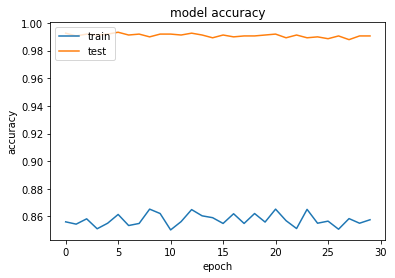

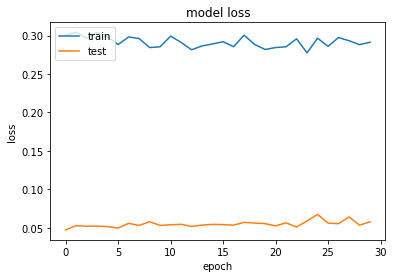

In [16]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Normalized confusion matrix
[[0.86938776 0.01768707 0.11292517]
 [0.16538462 0.66538462 0.16923077]
 [0.11187215 0.02853881 0.85958904]]


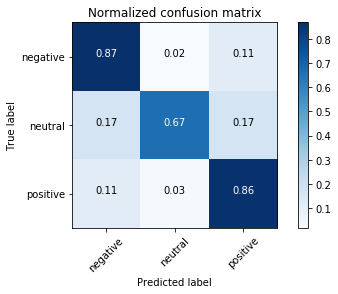

In [17]:
#Confusion Matrix

y_score = model.predict(X_val)

import itertools

score = ['negative', 'neutral','positive']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greys):
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(set(score)))
#     plt.xticks(tick_marks, score, rotation=45)
#     plt.yticks(tick_marks, score)
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
    
# Compute confusion matrix
# cm = confusion_matrix(Y_val[:,1], np.round(yhat[:,1]))
# np.set_printoptions(precision=3)
# plt.figure()
# plot_confusion_matrix(cm)    

# cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# plt.figure()
# plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

# plt.show()

yFit_class = np.argmax(y_score, axis=1)
yVal_class = np.argmax(Y_val, axis=1)

plot_confusion_matrix(confusion_matrix(yVal_class, yFit_class, labels=[0,1,2]), 
                      classes=['negative','neutral','positive'], 
                      normalize=True,
                      title='Normalized confusion matrix')


In [18]:
# #load the best model
# best_model = load_model(f_chkpt_h5, custom_objects={"KMaxPooling": KMaxPooling})

# # serialize model to JSON
# model_json = best_model.to_json()
# with open(f_model_json, "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# best_model.save_weights(f_model_weights)

#for the custom layers, Keras can't do it correctly when some layer is reshape. 
#workaround is to separately define a model and load only weight
#https://github.com/farizrahman4u/seq2seq/issues/144

best_model = model
print(best_model.summary())
best_model.load_weights(f_chkpt_h5)
best_model.save_weights(f_model_weights)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 128)          2560000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 64)            41024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 24, 64)            4160      
__________

In [19]:
#load old model

# with open(f_model_json) as ff:
#     model_json=ff.read()
#     extract_model=keras.models.model_from_json(model_json)
# extract_model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])
extract_model = model
extract_model.load_weights(f_model_weights)

yFit = extract_model.predict(X_val, batch_size=10, verbose=1)
yFit_class = np.argmax(yFit, axis=1)

1871/1871 [==============================] - 1s 567us/step


In [20]:
t = 0

if Y_val[t][0]==1: label_answer = "negative"
elif Y_val[t][1]==1: label_answer = "neutral"
else: label_answer = "positive"

if yFit_class[t]==0: predict_answer = "negative"
elif yFit_class[t]==1: predict_answer = "negative"
else: predict_answer = "negative"

temp_text = ''
for each in X_val[t]:
    if each != 0:
        temp_text=temp_text+(str(list(vocab_to_int.keys())[list(vocab_to_int.values()).index(each)]))

print('Text = '+temp_text+'\nLabel = '+label_answer+'\nPredict = '+predict_answer)

Text = ทองรูปพรรณส.ค.ขายออกบาทละบาท
Label = neutral
Predict = negative


In [21]:
t = 5

if Y_val[t][0]==1: label_answer = "negative"
elif Y_val[t][1]==1: label_answer = "neutral"
else: label_answer = "positive"

if yFit_class[t]==0: predict_answer = "negative"
elif yFit_class[t]==1: predict_answer = "negative"
else: predict_answer = "negative"

temp_text = ''
for each in X_val[t]:
    if each != 0:
        temp_text=temp_text+(str(list(vocab_to_int.keys())[list(vocab_to_int.values()).index(each)]))

print('Text = '+temp_text+'\nLabel = '+label_answer+'\nPredict = '+predict_answer)

Text = หุ้นสหรัฐปิดบวกจากแรงหนุนกลุ่มพลังงาน-เทคโนโลยี
Label = positive
Predict = negative


In [22]:
t = 2

if Y_val[t][0]==1: label_answer = "negative"
elif Y_val[t][1]==1: label_answer = "neutral"
else: label_answer = "positive"

if yFit_class[t]==0: predict_answer = "negative"
elif yFit_class[t]==1: predict_answer = "negative"
else: predict_answer = "negative"

temp_text = ''
for each in X_val[t]:
    if each != 0:
        temp_text=temp_text+(str(list(vocab_to_int.keys())[list(vocab_to_int.values()).index(each)]))

print('Text = '+temp_text+'\nLabel = '+label_answer+'\nPredict = '+predict_answer)

Text = ต่อยอดความฟินส่งแก๊งค์LINEFRIENDSโหนกระแสบอลโลก
Label = neutral
Predict = negative


In [23]:
t = 17

if Y_val[t][0]==1: label_answer = "negative"
elif Y_val[t][1]==1: label_answer = "neutral"
else: label_answer = "positive"

if yFit_class[t]==0: predict_answer = "negative"
elif yFit_class[t]==1: predict_answer = "negative"
else: predict_answer = "negative"

temp_text = ''
for each in X_val[t]:
    if each != 0:
        temp_text=temp_text+(str(list(vocab_to_int.keys())[list(vocab_to_int.values()).index(each)]))

print('Text = '+temp_text+'\nLabel = '+label_answer+'\nPredict = '+predict_answer)

Text = SETปิดตลาดเช้าลบลบVolลบ.
Label = negative
Predict = negative


In [24]:
scores = model.evaluate(X_val, Y_val, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1871/1871 [==============================] - 0s 220us/step
Accuracy: 83.11%


1871/1871 [==============================] - 0s 157us/step


| Labels\Metrics   |   Precision |   Recall |   F-Score |   Support |
|:-----------------|------------:|---------:|----------:|----------:|
| negative         |    0.839833 | 0.820408 |  0.830007 |       735 |
| neutral          |    0.812785 | 0.684615 |  0.743215 |       260 |
| positive         |    0.828694 | 0.883562 |  0.855249 |       876 |


Precision: 0.830859
Recall: 0.831106
F1: 0.829764
Accuracy: 0.831106


Normalized confusion matrix
[[0.82040816 0.0244898  0.15510204]
 [0.13846154 0.68461538 0.17692308]
 [0.09018265 0.02625571 0.88356164]]




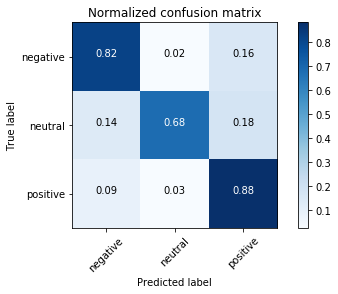

In [25]:
#sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

#more
from IPython.display import HTML, display
import tabulate
import itertools

yFit = best_model.predict(X_val, batch_size=batch_size, verbose=1)
yFit_class = np.argmax(yFit, axis=1)
yVal_class = np.argmax(Y_val, axis=1)

precision, recall, fscore, support = score(yVal_class, yFit_class, 
                                           average=None,labels = [0, 1, 2])

table = [['negative',precision[0],recall[0],fscore[0],support[0]],
['neutral',precision[1],recall[1],fscore[1],support[1]],
['positive',precision[2],recall[2],fscore[2],support[2]]]

#display(HTML(tabulate.tabulate(table, tablefmt='html', headers=['Labels\Metrics','Precision', 'Recall', 'F-Score', 'Support'])))
print("\n")
print(tabulate.tabulate(table, tablefmt='pipe', headers=['Labels\Metrics','Precision', 'Recall', 'F-Score', 'Support']))

print("\n")
w_precision = format(precision_score(yVal_class, yFit_class, average='weighted'),'.6f')
w_recall = format(recall_score(yVal_class, yFit_class, average='weighted'),'.6f')
w_fscore = format(f1_score(yVal_class, yFit_class, average='weighted'),'.6f')
w_accuracy = format(accuracy_score(yVal_class, yFit_class, normalize=True),'.6f')
#w_roc = format(roc_auc_score(yVal_class, yFit_class, average='weighted'),'.6f')
print("Precision: %s" % w_precision)
print("Recall: %s" % w_recall)
print("F1: %s" % w_fscore)
print("Accuracy: %s" % w_accuracy)

print("\n")
#plt.figure()
plot_confusion_matrix(confusion_matrix(yVal_class, yFit_class, labels=[0,1,2]), 
                      classes=['negative','neutral','positive'], 
                      normalize=True,
                      title='Normalized confusion matrix')


print("\n")
display(HTML(tabulate.tabulate(table, tablefmt='latex', headers=['Labels\Metrics','Precision', 'Recall', 'F-Score', 'Support'])))


In [ ]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")